<a href="https://colab.research.google.com/github/Ohmyprogram/Delivery-Robot-TextMining/blob/main/%EA%B0%90%EC%84%B1%EC%9D%BC%EA%B8%B0_Word2vec_%EC%9C%A0%EC%82%AC%EB%8B%A8%EC%96%B4%EC%B6%94%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

# 1. 코랩 환경 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 디렉토리 변경
%cd drive/MyDrive/혁신기술텍스트마이닝/윤아

/content/drive/MyDrive/혁신기술텍스트마이닝/윤아


In [ ]:
# 현재 디렉토리 경로 확인
!pwd

/content/drive/MyDrive/혁신기술텍스트마이닝/윤아


# 2. 형태소 분석에 필요한 패키지 import

In [ ]:
# !pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 453 kB 51.6 MB/s 


In [ ]:
import io
import pandas as pd
import csv
from konlpy.tag import Komoran
from collections import defaultdict
import sys
import regex
import warnings
import copy
from tqdm import tqdm
from gensim import corpora
from gensim import models
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict

warnings.filterwarnings('ignore')

## 사용자 정의 사전 등록

In [ ]:
# # STABLE or EXP
komoran = Komoran(userdic='/content/drive/MyDrive/혁신기술텍스트마이닝/윤아/dic/user_dictionary.txt') # userdic 추가
# komoran = Komoran("EXP")
# komoran.set_user_dic("/content/drive/MyDrive/혁신기술텍스트마이닝/dic/user_dictionary.txt")  #사용자 정의 사전 등록

#4. 점수 산출과정에서 필요한 함수 정의

- Seperator_part : 한문장을 넣으면 형태소분석결과 리턴해주는 함수

In [ ]:
## Seperator_part(한문장)
##한 문장에 대해 형태소 분석하고 (단어, 품사) 형태로 결과를 리턴해주는 함수

def Seperator_part(oneL):
  #slash_line = komoran.get_list(oneL)
  slash_line = komoran.pos(oneL)

  # (단어,품사) 형태로 만들기
  tagged_list = []
  for i in range(len(slash_line)):
      a = str(slash_line[i]).split('/')
      tagged_list.append(a)

  for j in tagged_list:
      if len(j) != 2:
          tagged_list.remove(j)

  return tagged_list

- remove_word_by_tag : 형태소 분석결과(단어,품사)를 넣으면 점수계산할 때 필요한 태그만 리턴해주는 함수

In [ ]:
# 고려하지 않는 태그는 버리는 함수
def remove_word_by_tag(x):
    temp = list()
    tag_list = ['NNG','NNP', 'VV', 'VA', 'XR'] #고려하는 태그 목록
    for k in range(len(x)):
        if x[k][1] in tag_list:
            temp.append(x[k])
        else:
            continue
    return temp

# 데이터 전처리

In [ ]:
raw_data = pd.read_excel('/content/drive/MyDrive/혁신기술텍스트마이닝/data/raw_data.xlsx')
raw_data.head()

In [ ]:
# nan값 제거,맞춤법,'";"등 . , 제외한 다른 기호 제거
raw_data.isnull().sum()

In [ ]:
clean_df = raw_data.dropna()
clean_df.isnull().sum()

느낀점    0
dtype: int64

In [ ]:
# 텍스트 전처리
def cleanText(text):
  specialChar = '[-=+#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》❤♥♡ㅏㅑㅓㅑㅗㅛㅜㅠㅢㅡㅣㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㄲㄸㅆㅉㅃ]'
  text = ''.join(c for c in text if c not in specialChar)
  only_BMP_pattern = re.compile("["
        u"\U00010000-\U0010FFFF"  #BMP characters 이외 (이모지 제거)
                           "]+", flags=re.UNICODE)
  return only_BMP_pattern.sub(r'', text)

# 맞춤법 검사
def spell_check(comments):
  for k in tqdm(range(len(comments))):
    comments[k] = cleanText(comments[k])
    spelled_sent = spell_checker.check(comments[k])
    checked_sent = spelled_sent.checked
    comments[k] = checked_sent
  print("맞춤법 검사 완료")

  #return comments.to_csv(bank_name+'_spell_checked.csv')


spell_check(clean_df['comment'])
clean_df.to_csv("comments_spell_checked.csv")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/혁신기술텍스트마이닝/윤아/data/comments_spell_checked.csv")
df = df.drop(['Unnamed: 0'], axis = "columns")
df.rename(columns = {"느낀점":"Content"}, inplace = True)
df.head()

,Content
0,시도한지 20분이 지나도 배차가 되지 않아서 결국 버스로 환승
1,호출했으나 이번에도 배차가 30분 정도 되지 않음
2,운 좋게 배차가 됐고 약 20분 후에 도착한다고 바로 알림
3,예상 시간과 비슷한 시간에 탑승
4,QR코드를 기기에 태그 하기만 하면 돼서 간편


In [ ]:
POS = [komoran.pos(s) for s in df['Content']]
WORD = [remove_word_by_tag(p) for p in POS]
df['POS'] = WORD
df.head()

,Content,POS
0,시도한지 20분이 지나도 배차가 되지 않아서 결국 버스로 환승,"[(시도, NNG), (지나, VV), (배, NNG), (차, NNG), (되, ..."
1,호출했으나 이번에도 배차가 30분 정도 되지 않음,"[(호출, NNG), (이번, NNG), (배, NNG), (차, NNG), (정도..."
2,운 좋게 배차가 됐고 약 20분 후에 도착한다고 바로 알림,"[(울, VV), (좋, VA), (배, NNG), (차, NNG), (되, VV)..."
3,예상 시간과 비슷한 시간에 탑승,"[(예상, NNG), (시간, NNG), (비슷, XR), (시간, NNG), (탑..."
4,QR코드를 기기에 태그 하기만 하면 돼서 간편,"[(코드, NNP), (기기, NNG), (태그, NNP), (하, VV), (하,..."


In [ ]:
emo_dic = pd.read_excel("/content/drive/MyDrive/혁신기술텍스트마이닝/윤아/dic/emo_dic.xlsx")
emo_word= list(emo_dic['WORD'])

In [ ]:
word = []
for p in df['POS']:
  ls = [p[k][0] for k in range(len(p)) if len(p[k][0]) > 1 or p[k][0] in emo_dic]
  word.append(ls)

df['WORD'] = word

In [ ]:
df.head()

,Content,POS,WORD
0,시도한지 20분이 지나도 배차가 되지 않아서 결국 버스로 환승,"[(시도, NNG), (지나, VV), (배, NNG), (차, NNG), (되, ...","[시도, 지나, 버스, 환승]"
1,호출했으나 이번에도 배차가 30분 정도 되지 않음,"[(호출, NNG), (이번, NNG), (배, NNG), (차, NNG), (정도...","[호출, 이번, 정도]"
2,운 좋게 배차가 됐고 약 20분 후에 도착한다고 바로 알림,"[(울, VV), (좋, VA), (배, NNG), (차, NNG), (되, VV)...","[도착, 알리]"
3,예상 시간과 비슷한 시간에 탑승,"[(예상, NNG), (시간, NNG), (비슷, XR), (시간, NNG), (탑...","[예상, 시간, 비슷, 시간, 탑승]"
4,QR코드를 기기에 태그 하기만 하면 돼서 간편,"[(코드, NNP), (기기, NNG), (태그, NNP), (하, VV), (하,...","[코드, 기기, 태그, 간편]"


In [ ]:
# !pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 텍스트 파일을 읽어와서, 전처리 수행 후에 model 파일로 저장하기
from gensim.models import Word2Vec

model = Word2Vec(sentences = list(df['WORD']), size = 100, window = 5, min_count = 5, workers = 4, sg = 0)
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(92, 100)

In [ ]:
print(model.wv.most_similar("불편"))
similar_word = model.wv.most_similar("불편")

[('서비스', 0.21263375878334045), ('하차', 0.20523323118686676), ('아이', 0.16560611128807068), ('아이들', 0.15366514027118683), ('호출', 0.15068116784095764), ('대중교통', 0.1479957550764084), ('노선', 0.13210245966911316), ('경험', 0.12940090894699097), ('빠르', 0.1292206048965454), ('이동', 0.11937612295150757)]


In [ ]:
similar_word_df = pd.DataFrame(similar_word)
similar_word_df.columns=["유사단어","유사도"]
similar_word_df

,유사단어,유사도
0,서비스,0.212634
1,하차,0.205233
2,아이,0.165606
3,아이들,0.153665
4,호출,0.150681
5,대중교통,0.147996
6,노선,0.132102
7,경험,0.129401
8,빠르,0.129221
9,이동,0.119376


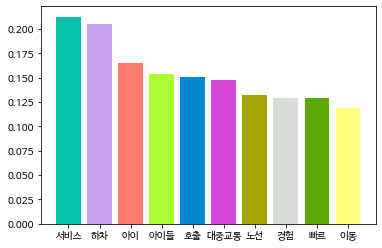

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

# 바 그래프 그리기
def showGraph(bargraph):
     xtick = [item[0] for item in bargraph] # 단어
     ytick = [item[1] for item in bargraph] # 유사도
     plt.figure()
     mycolors = ['#06c2ac', '#c79fef', '#ff796c', '#aaff32', '#0485d1', '#d648d7', '#a5a502', '#d8dcd6', '#5ca904', '#fffe7a' ]
     plt.bar(xtick, ytick, color=mycolors)

similar_word = model.wv.most_similar("불편", topn=10)
showGraph(similar_word)

plt.show()

In [ ]:
word_vectors = model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys=xys[:,1]

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

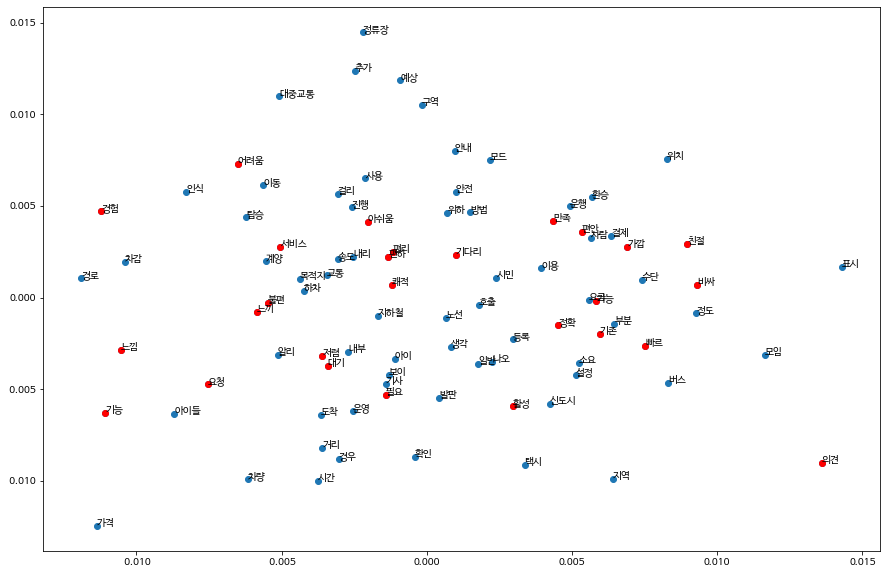

In [ ]:
import matplotlib.pyplot as plt

def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(15,10))
    plt.scatter(xs,ys,marker='o')
    for i,v in enumerate(vocabs):
        plt.annotate(v,xy=(xs[i], ys[i]))
        if v in emo_word :
          plt.scatter(xs[i], ys[i], c = 'red')

plot_2d_graph(vocabs, xs,ys)

## html로 만들기

In [ ]:
# annotation text 만들기 (시각화할 때 벡터 말고 단어도 필요하니까)
# vocabs = word_vectors.vocab.keys()

text=[]
for i,v in enumerate(vocabs):
    text.append(v)

In [ ]:
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(15,10))
    plt.scatter(xs,ys,marker='o')
    for i,v in enumerate(vocabs):
        plt.annotate(v,xy=(xs[i], ys[i]))
        if v in emo_word :
          plt.scatter(xs[i], ys[i], c = 'red')

plot_2d_graph(vocabs, xs,ys)

In [ ]:
import plotly
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(x=xs,
                                y=ys,
                                mode='markers+text',
                                text=text))

exs = []; eys = [] ; etext = []
for i, v in enumerate(vocabs):
  if v in emo_word:
    exs.append(xs[i])
    eys.append(ys[i])
    etext.append(v)

fig.add_trace(go.Scatter(x=exs, y=eys, mode = 'markers+text',text = etext, name = "Emotion"))

fig.update_layout(title='Delivery Word2Vec')
fig.show()

In [ ]:
plotly.offline.plot(
fig, filename='Delivery_word2vec.html'
)

'Delivery_word2vec.html'